# Compiling the building footprints of Electrical substations (onderstations)

The objective of this notebook is to compile a data set consisting of electrical substation footprints as a supporting solution for lvc reconstructor and path-finder problem.

In [1]:
import geopandas as gpd
import pyproj
import osmnx  as ox

/var/folders/bh/hhr2wkwn2ldcpz5w4tgn7sb80000gn/T/ipykernel_52578/3866812771.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
CRS = 4326

stations = gpd.read_parquet('../../data/liander/onderstations.pyarrow')
stations = stations.to_crs(pyproj.CRS.from_epsg(CRS))
stations.head()

,id,geometry
0,680162505,POINT (4.96553 52.33297)
1,724198747,POINT (5.72333 52.84813)
2,728801999,POINT (5.76228 52.68395)
3,760866446,POINT (6.37847 51.90356)
4,764986551,POINT (6.21951 52.14935)


In [181]:
verzorgingsgebied = gpd.read_parquet('../../data/atom/verzorgingsgebied.parquet')
verzorgingsgebied = verzorgingsgebied.to_crs(CRS)
verzorgingsgebied.head()

,id,station,netbeheerder,status,totaleCapaciteitInvoedingMva,totaleCapaciteitAfnameMva,beschikbareCapaciteitInvoedingHuidigMva,beschikbareCapaciteitAfnameHuidigMva,verwachtJaarVanOverbelastingInvoeding,verwachtJaarVanOverbelastingAfname,...,peildatum,beschikbareCapaciteitAfname3JaarMvaVisualisatie,beschikbareCapaciteitAfname5JaarMvaVisualisatie,beschikbareCapaciteitAfname10JaarMvaVisualisatie,beschikbareCapaciteitAfnameHuidigMvaVisualisatie,beschikbareCapaciteitInvoeding3JaarMvaVisualisatie,beschikbareCapaciteitInvoeding5JaarMvaVisualisatie,beschikbareCapaciteitInvoeding10JaarMvaVisualisatie,beschikbareCapaciteitInvoedingHuidigMvaVisualisatie,geometry
0,indicatief_verzorgingsgebied.3f7b1732-778d-4b1...,Wittevrouweveld,Enexis,Bestaand,35,35,34.0,10.0,2028,2035,...,2022-12-14,10,10,10,10,34,34,34,34,"MULTIPOLYGON (((5.66455 50.83226, 5.70274 50.8..."
1,indicatief_verzorgingsgebied.0a727e27-ba60-487...,Boschpoort,Enexis,Bestaand,45,45,6.0,23.0,2023,2035,...,2022-12-14,23,23,23,23,6,6,6,6,"MULTIPOLYGON (((5.64897 50.82704, 5.64918 50.8..."
2,indicatief_verzorgingsgebied.ed973a51-edcc-40e...,Heer,Enexis,Bestaand,40,40,38.0,0.0,2028,2023,...,2022-12-14,0,0,0,0,38,38,38,38,"MULTIPOLYGON (((5.83113 50.75886, 5.83102 50.7..."
3,indicatief_verzorgingsgebied.9e164099-7d30-41a...,Schoonbron,Enexis,Bestaand,45,47,0.0,0.0,2023,2023,...,2022-12-14,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((5.91508 50.75040, 5.91508 50.7..."
4,indicatief_verzorgingsgebied.adc9060f-a6b2-4dd...,Terwinselen,Enexis,Bestaand,110,116,0.0,0.0,2023,2023,...,2022-12-14,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((6.05465 50.92368, 6.05450 50.9..."


In [4]:
ms = gpd.read_parquet('../../data/liander/middenspanningskabels.pyarrow')
ms = ms.to_crs(pyproj.CRS.from_epsg(CRS))
ms.head()

,id,geometry
0,10255800,"LINESTRING (5.71308 51.93644, 5.71308 51.93644..."
1,10255816,"LINESTRING (5.55664 51.92032, 5.55665 51.92031..."
2,10255842,"LINESTRING (5.51975 51.94033, 5.51987 51.94030..."
3,10255858,"LINESTRING (5.52608 51.96371, 5.52661 51.96372..."
4,10255872,"LINESTRING (5.75006 51.90587, 5.75009 51.90582..."


In [146]:
%%time
%%capture

import warnings
warnings.filterwarnings('ignore')

samples = stations.iloc[:10, :]

foot_prints = []

for sample in samples.values:
    coords = sample[1].coords
    poi = (coords[0][1], coords[0][0])
    foot_print = ox.geometries_from_point(poi, {"building": True}, dist=160)
    foot_print = foot_print[foot_print['building'] == 'yes']
    foot_prints.append(foot_print)

CPU times: user 222 ms, sys: 16 ms, total: 238 ms
Wall time: 245 ms


In [167]:
poi_idx = 0
foot_prints[poi_idx]

geometry  \
element_type osmid                                                          
way          278716181  POLYGON ((4.96325 52.33437, 4.96330 52.33439, ...   
             278868707  POLYGON ((4.96655 52.33325, 4.96657 52.33328, ...   
             278868713  POLYGON ((4.96884 52.33150, 4.96886 52.33154, ...   
             278868721  POLYGON ((4.96590 52.33117, 4.96466 52.33146, ...   
             278868747  POLYGON ((4.96775 52.33369, 4.96743 52.33387, ...   
             278868752  POLYGON ((4.96607 52.33188, 4.96608 52.33190, ...   
             278868760  POLYGON ((4.96572 52.33319, 4.96526 52.33329, ...   
             278868767  POLYGON ((4.96565 52.33184, 4.96548 52.33188, ...   
             278868768  POLYGON ((4.96778 52.33242, 4.96781 52.33246, ...   
             278868770  POLYGON ((4.96582 52.33180, 4.96565 52.33184, ...   
             278868772  POLYGON ((4.96704 52.33430, 4.96683 52.33442, ...   
             278868777  POLYGON ((4.96612 52.33214, 4.96634 52.33248, ...   
             278868800  POLYGON ((4.96776 52.33436, 4.96768 52.33438, ...   
             278868809  POLYGON ((4.96479 52.33205, 4.96483 52.33211, ...   
             278868816  POLYGON ((4.96595 52.33411, 4.96605 52.33418, ...   
             278868823  POLYGON ((4.96772 52.33430, 4.96777 52.33427, ...   
             278868824  POLYGON ((4.96548 52.33188, 4.96531 52.33192, ...   
             278868837  POLYGON ((4.96337 52.33173, 4.96333 52.33174, ...   
             278868856  POLYGON ((4.96627 52.33364, 4.96631 52.33370, ...   
             278868862  POLYGON ((4.96593 52.33165, 4.96596 52.33169, ...   
             278868873  POLYGON ((4.96670 52.33216, 4.96673 52.33221, ...   
             278868875  POLYGON ((4.96514 52.33196, 4.96519 52.33206, ...   
             278868896  POLYGON ((4.96734 52.33341, 4.96726 52.33343, ...   
             278868902  POLYGON ((4.96579 52.33333, 4.96536 52.33343, ...   
             278868930  POLYGON ((4.96487 52.33268, 4.96489 52.33267, ...   
             278868953  POLYGON ((4.96523 52.33322, 4.96550 52.33315, ...   
             278868965  POLYGON ((4.96562 52.33392, 4.96557 52.33394, ...   
             278869025  POLYGON ((4.96616 52.33436, 4.96616 52.33436, ...   
             278869036  POLYGON ((4.96674 52.33133, 4.96642 52.33140, ...   
             278869048  POLYGON ((4.96600 52.33176, 4.96582 52.33180, ...   
             278869067  POLYGON ((4.96595 52.33411, 4.96622 52.33395, ...   
             278869103  POLYGON ((4.96500 52.33207, 4.96502 52.33210, ...   
             492173494  POLYGON ((4.96460 52.33357, 4.96481 52.33368, ...   
             492173495  POLYGON ((4.96509 52.33363, 4.96531 52.33358, ...   
             564445857  POLYGON ((4.96399 52.33284, 4.96396 52.33280, ...   
             839582997  POLYGON ((4.96677 52.33437, 4.96670 52.33432, ...   
             842230520  POLYGON ((4.96366 52.33217, 4.96369 52.33216, ...   
             842334229  POLYGON ((4.96644 52.33271, 4.96651 52.33269, ...   

                                                                    nodes  \
element_type osmid                                                          
way          278716181  [2830315579, 2830315593, 2830315558, 283031554...   
             278868707  [2831614822, 2831614832, 7858304321, 283161470...   
             278868713  [2831613201, 2831613210, 2831613214, 283161320...   
             278868721  [2831612885, 2831612392, 7856653367, 283161347...   
             278868747  [2831615130, 2831615159, 2831615136, 283161399...   
             278868752  [2831613466, 2831613478, 2831613471, 283161346...   
             278868760  [2831614803, 2831614836, 2831614872, 283161483...   
             278868767  [2831613448, 2831613473, 2831613711, 785740713...   
             278868768  [2831613581, 2831614225, 2831613598, 283161411...   
             278868770  [2831613424, 2831613448, 2831612994, 785740713...   
             278868772  [2831615237, 7834405107, 2831615252,

In [ ]:
to_save = foot_prints[poi_idx].explore(popup='ref:bag')
to_save.save('test.html')

### Unfortunately, this proces requires manual determination for more accurate footprint

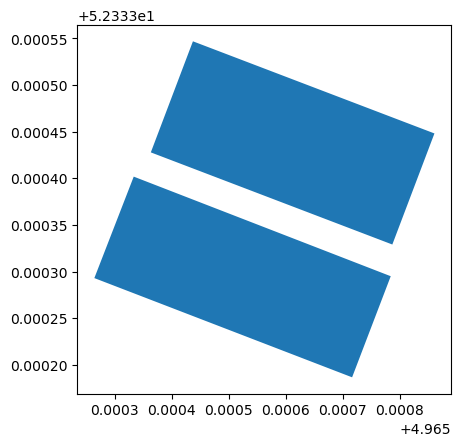

In [184]:
buildings_of_interest = ['384100000001727', '384100000001678']
buildings_one = foot_prints[poi_idx][foot_prints[poi_idx]['ref:bag'].isin(buildings_of_interest)]
buildings_one.plot();

In [179]:
buildings_one.power = ['OS VENSERWEG'] * 2
buildings_one[['ref:bag', 'power', 'geometry']]

ref:bag         power  \
element_type osmid                                      
way          278868760  384100000001678  OS VENSERWEG   
             278868902  384100000001727  OS VENSERWEG   

                                                                 geometry  
element_type osmid                                                         
way          278868760  POLYGON ((4.96572 52.33319, 4.96526 52.33329, ...  
             278868902  POLYGON ((4.96579 52.33333, 4.96536 52.33343, ...

In [182]:
len(stations), len(verzorgingsgebied)

(126, 343)

In [166]:
# %%time
#
# import warnings
# warnings.filterwarnings('ignore')
#
# buildings = {}
#
# for idx, foot_print in enumerate(foot_prints):
#     print(f'Started: idx: {idx}')
#     for building_idx in range(len(foot_print)):
#         print('Inner')
#         d = foot_print.iloc[building_idx].geometry.distance(ms.geometry)
#         d_idx = d[d <= 0.000003].index
#         if len(d_idx) > 0:
#             if idx not in buildings:
#                 buildings[idx] = [foot_print.iloc[building_idx, 0]]
#             else:
#                 buildings[idx] = buildings[idx] + [foot_print.iloc[building_idx, 0]]
#
#     print(f'Finished: idx: {idx}')
#     break